In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import glob 
from datetime import datetime

In [3]:
# Function to form a dataframe based. Takes in folder name as argument and returns a df for every year
def get_data(name):
    df = {}
    for year in range(2009,2022):
        df_by_year = []
        path = f'/home/agam/Desktop/git_projects/nyc-taxi-trip/data/query-data/{year}/{name}/'
        path_list = glob.glob(path+'*.csv')
        for p in path_list:
            try:
                df_by_year.append(pd.read_csv(p))
            except:
                continue
        try:
            df[str(year)] = pd.concat(df_by_year,axis=0)
        except:
            continue
    return df


# Hour of Day

In [4]:
df = get_data(name='avg_dur_hod')

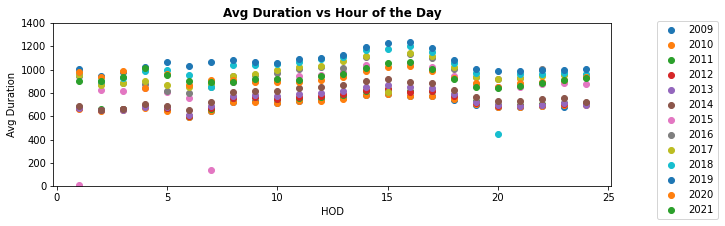

In [5]:
fig = plt.figure(figsize=(10,3))
ax = plt.gca()
ax.set_ylim([0, 1400])
for year in df.keys():
    x=df[year].iloc[:,0]
    y=df[year].iloc[:,1]
    plt.scatter(x,y,label=year)
    plt.legend(loc=1,bbox_to_anchor=(1.2,1.045))
plt.title('Avg Duration vs Hour of the Day',fontweight='bold')
plt.xlabel('HOD')
plt.ylabel('Avg Duration')
plt.show()

For year 2015, hour 0001 and 0007 have expentionally small avergae duration. Although one can see the pattern but limiting the y-axis range will show it clearer.

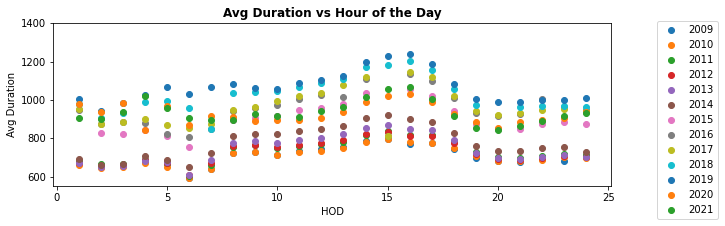

In [6]:
fig = plt.figure(figsize=(10,3))
ax = plt.gca()
ax.set_ylim([550, 1400])
for year in df.keys():
    x=df[year].iloc[:,0]
    y=df[year].iloc[:,1]
    plt.scatter(x,y,label=year)
    plt.legend(loc=1,bbox_to_anchor=(1.2,1.045))
plt.title('Avg Duration vs Hour of the Day',fontweight='bold')
plt.xlabel('HOD')
plt.ylabel('Avg Duration')
plt.show()

There is defintely a pattern here. The interval between 2 PM and 5 PM has the highest average duration. After 5 PM, average duration starts to gradually decline. This pattern at hourly level seems like a good candidate for a new feature. I'll impute median average duration for the hour of the day.

In [7]:
# Calculating median from a list of avg duration from 2009 to 2021
df_joined = df['2009'].merge(df['2010'],on='H_O_D',suffixes=('2009','2010'))
for year in list(df.keys())[2:]:
    df_joined=df_joined.merge(df[year],on='H_O_D',suffixes=('',year))
df_joined.sort_values('H_O_D',inplace=True)
df_joined.reset_index(drop=True,inplace=True)
df_joined['median']=df_joined.iloc[:,1:].median(axis=1)
df_joined.loc[:,['H_O_D','median']].head()

,H_O_D,median
0,1,689.700188
1,2,825.198993
2,3,820.265321
3,4,840.704967
4,5,809.380304


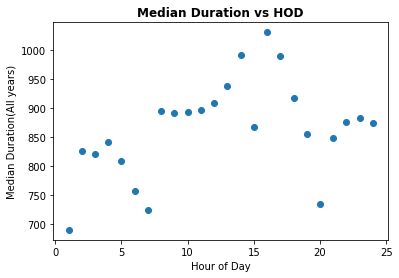

In [8]:
x=df_joined.loc[:,'H_O_D']
y=df_joined.loc[:,'median']
plt.scatter(x,y)
plt.title('Median Duration vs HOD',fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Median Duration(All years)')
plt.show()

# Day of Week

In [9]:
df = get_data(name='avg_dur_dow')

In [10]:
# Sorting df on Day of Week for plotting purpose
dic = {'Thu':4, 'Fri':5, 'Sat':6, 'Wed':3, 'Sun':7, 'Tue':2, 'Mon':1}
def convert(x):
    return dic[x]
for year in df.keys():
    df[year].iloc[:,0]=df[year]['D_O_W'].apply(convert)
    df[year] = df[year].sort_values('D_O_W')

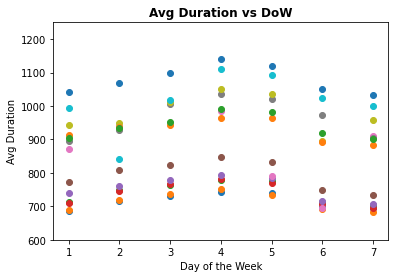

In [11]:
ax = plt.gca()
ax.set_ylim([600, 1250])
for year in df.keys():
    x=df[year].iloc[:,0]
    y=df[year].iloc[:,1]
    plt.scatter(x,y,label=year)
plt.title('Avg Duration vs DoW',fontweight='bold')
plt.xlabel('Day of the Week')
plt.ylabel('Avg Duration')
plt.show()

This pattern can also be used for creating a new feature.

In [12]:
# Calculating median from a list of avg duration from 2009 to 2021
df_joined = df['2009'].merge(df['2010'],on='D_O_W',suffixes=('2009','2010'))
for year in list(df.keys())[2:]:
    df_joined=df_joined.merge(df[year],on='D_O_W',suffixes=('',year))
df_joined.sort_values('D_O_W',inplace=True)
df_joined.reset_index(drop=True,inplace=True)
df_joined['median']=df_joined.iloc[:,1:].median(axis=1)
df_joined.loc[:,['D_O_W','median']].head()

,D_O_W,median
0,1,871.824557
1,2,842.664936
2,3,942.328157
3,4,963.090874
4,5,833.535638


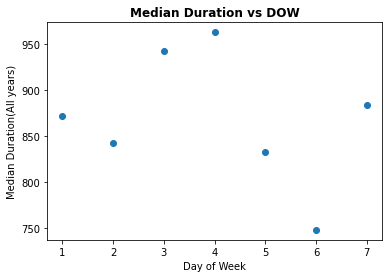

In [14]:
x=df_joined.loc[:,'D_O_W']
y=df_joined.loc[:,'median']
plt.scatter(x,y)
plt.title('Median Duration vs DOW',fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Median Duration(All years)')
plt.show()

# Month

In [15]:
df_pickup = get_data(name='daily_pickup_cnt')
df_dur = get_data(name='avg_dur_doy')

In [16]:
df_joined = {}
for year in df_pickup.keys():
        df_joined[year] = df_pickup[year].merge(df_dur[year],on='D_O_Y')
        df_joined[year]['duration'] = df_joined[year].loc[:,'avg_trip_duration']*df_joined[year].loc[:,'daily_count']

In [17]:
df_joined['2009'].head()

,D_O_Y,daily_count,avg_trip_duration,duration
0,18,419962,669.686276,281242788.0
1,28,455187,710.226415,323285831.0
2,304,542854,737.171129,400176296.0
3,281,526548,746.257866,392940587.0
4,316,533748,766.683472,409215770.0


In [18]:
# Converting day of the year to the month it belongs to
for year in df_joined.keys():
    def doy_to_month(day_num):
        day_num = str(day_num)
        day_num.rjust(3 + len(day_num), '0')
        month = datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%m")
        return month 
    df_joined[year]['month'] = df_joined[year].loc[:,'D_O_Y'].apply(doy_to_month)
    df_joined[year].drop(columns=['avg_trip_duration'],inplace=True)

In [19]:
df_joined['2009'].head()

,D_O_Y,daily_count,duration,month
0,18,419962,281242788.0,01
1,28,455187,323285831.0,01
2,304,542854,400176296.0,10
3,281,526548,392940587.0,10
4,316,533748,409215770.0,11


In [20]:
df_new = {}
for year in df_joined.keys():
    temp = df_joined[year].iloc[:,1:].groupby('month').sum().reset_index()
    temp['avg_dur_month'] = temp['duration']/temp['daily_count']
    df_new[year] = temp.loc[:,['month','avg_dur_month']]

In [21]:
df_new['2009'].head()

,month,avg_dur_month
0,01,693.908884
1,02,681.497975
2,03,707.094797
3,04,709.520006
4,05,723.956573


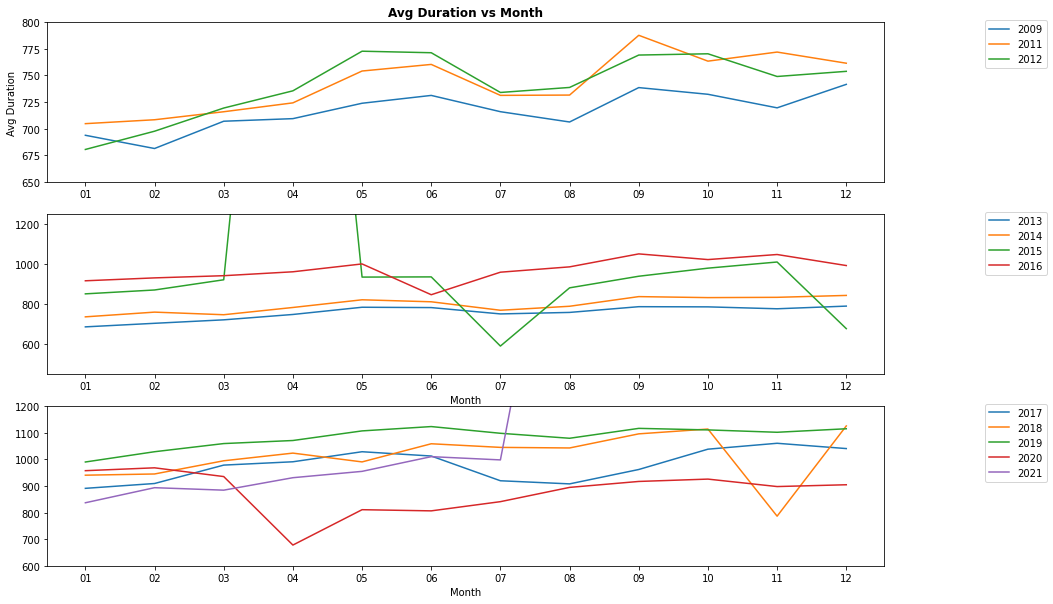

In [22]:
fig = plt.figure(figsize=(15,10))
t=1
i=1
limit = {1:[650,800],2:[450,1250],3:[600,1200]}
for year in df_new.keys():
    if t % 4 == 0 and t<=8:
        i+=1
    if i ==1:
        plt.title('Avg Duration vs Month',fontweight='bold')
        plt.ylabel('Avg Duration')
    elif i ==3:
        plt.xlabel('Month')
    x=df_new[year].iloc[:,0]
    y=df_new[year].iloc[:,1]
    plt.subplot(3, 1, i)
    plt.plot(x,y,label=year)
    ax = plt.gca()
    ax.set_ylim(limit[i])
    plt.legend(loc=1,bbox_to_anchor=(1.2,1.045))
    t+=1
plt.show()

# Total Revenue

In [57]:
df = get_data('total_rev')
df = pd.concat(df)
df.reset_index(inplace=True)
df.head()

,level_0,level_1,total_revenue
0,2009,0,1.867907e+09
1,2010,0,1.918269e+09
2,2011,0,2.162633e+09
3,2012,0,2.340989e+09
4,2013,0,2.561345e+09


<BarContainer object of 12 artists>

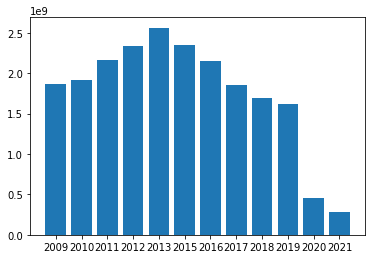

In [62]:
plt.bar(x=df['level_0'],height=df['total_revenue'])